# Packages, Data, Functions

In [1]:
# Import packages
import numpy as np
import skimage.io as skio
import skimage.morphology as skm
from skimage import feature
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from scipy.ndimage import gaussian_filter
from scipy.ndimage import gaussian_laplace

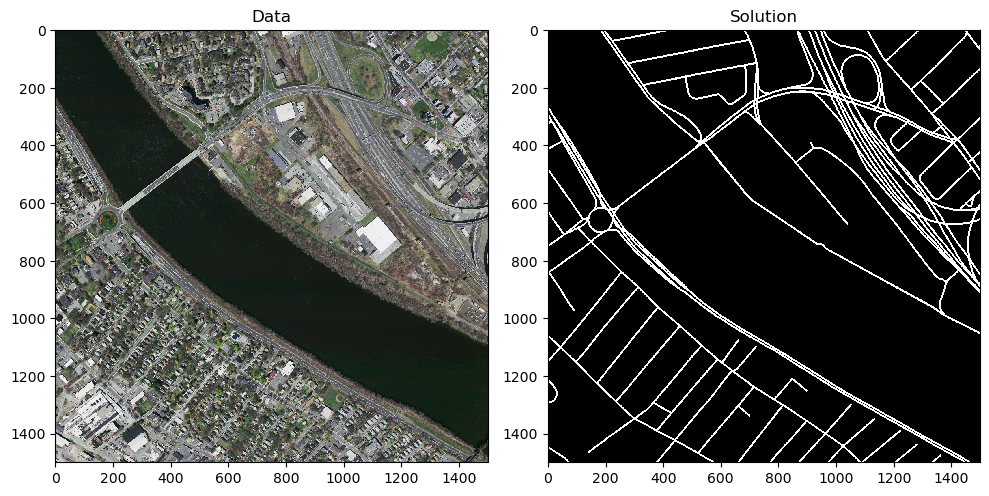

In [13]:
# Read the data
rgb = skio.imread("../../data/MA_roads/tiff/train/10828735_15.tiff")
ans = skio.imread("../../data/MA_roads/tiff/train_labels/10828735_15.tif")

rgb_test = skio.imread("../../data/MA_roads/tiff/train/21929005_15.tiff")
ans_test = skio.imread("../../data/MA_roads/tiff/train_labels/21929005_15.tif")

# Display training data and correct output
fig, ax = plt.subplots(1, 2, figsize = (10, 6))
skio.imshow(rgb, ax = ax[0])
ax[0].set_title("Data")
skio.imshow(ans, ax = ax[1])
ax[1].set_title("Solution");

In [3]:
# Function to print several accuracy metrics
def accuracy_metrics(y_true, y_pred):
    # Create confusion matrix
    C = confusion_matrix(y_true, y_pred)

    # Overall accuracy rate
    acc = (C[0,0] + C[1,1])/C.sum()

    # True positive rate
    tpr = (C[0,0])/(C[0,0] + C[0,1])
    
    # True negative rate
    tnr = (C[1,1])/(C[1,0] + C[1,1])

    # Print results
    print("Confusion matrix:\n", C)
    print("Overall accuracy:", np.round(acc, 3), "\nTrue positive rate (not road):", np.round(tpr, 3), "\nTrue negative rate (roads)", np.round(tnr, 3)) 

# Create Training and Testing Subsets

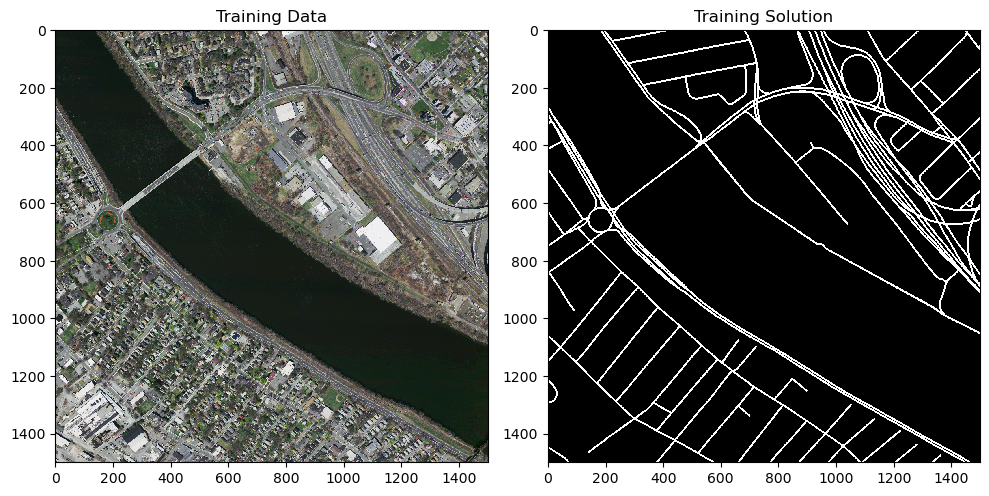

In [4]:
# Create training subset of data
# It takes too much computing power to run the model on the whole image on our own machines
# small_rgb = rgb[0:400, 1200:, :]
# small_ans = ans[0:400, 1200:]
small_rgb = rgb
small_ans = ans

fig, ax = plt.subplots(1, 2, figsize = (10, 6))
skio.imshow(small_rgb, ax = ax[0])
ax[0].set_title("Training Data")
skio.imshow(small_ans, ax = ax[1])
ax[1].set_title("Training Solution");

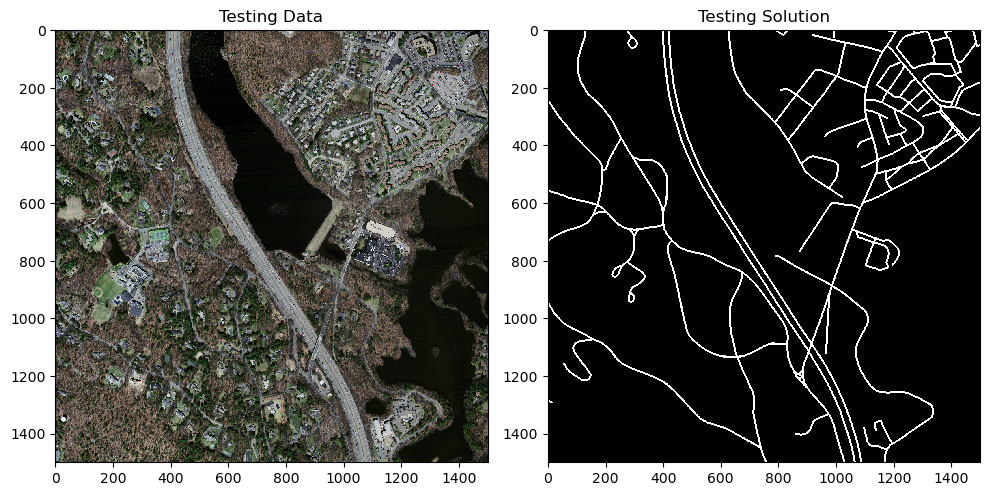

In [14]:
# Create testing subset of data
# It takes too much computing power to run the model on the whole image on our own machines
# small_rgb_test = rgb[1200:, 0:400, :]
# small_ans_test = ans[1200:, 0:400]
small_rgb_test = rgb_test
small_ans_test = ans_test

fig, ax = plt.subplots(1, 2, figsize = (10, 6))
skio.imshow(small_rgb_test, ax = ax[0])
ax[0].set_title("Testing Data")
skio.imshow(small_ans_test, ax = ax[1])
ax[1].set_title("Testing Solution");

# Random Forest Model: RGB
## Train model

In [7]:
# Flatten images
train_small_rgb = small_rgb.reshape(small_rgb.shape[0]*small_rgb.shape[1], 3)
y_train = small_ans.reshape(small_ans.shape[0]*small_ans.shape[1])

In [8]:
# Create model
RF = RandomForestClassifier()

# Fit and output the performance of the model
model1 = RF.fit(train_small_rgb, y_train)

In [9]:
# Predictions on training data
model1_pred = model1.predict(train_small_rgb)

# Confusion matrix
accuracy_metrics(y_train, model1_pred)

Confusion matrix:
 [[2006709   34711]
 [ 136140   72440]]
Overall accuracy: 0.924 
True positive rate (not road): 0.983 
True negative rate (roads) 0.347


While we have a really good overall accuracy rate, we are correctly predicting only 68.7% of the road pixels.

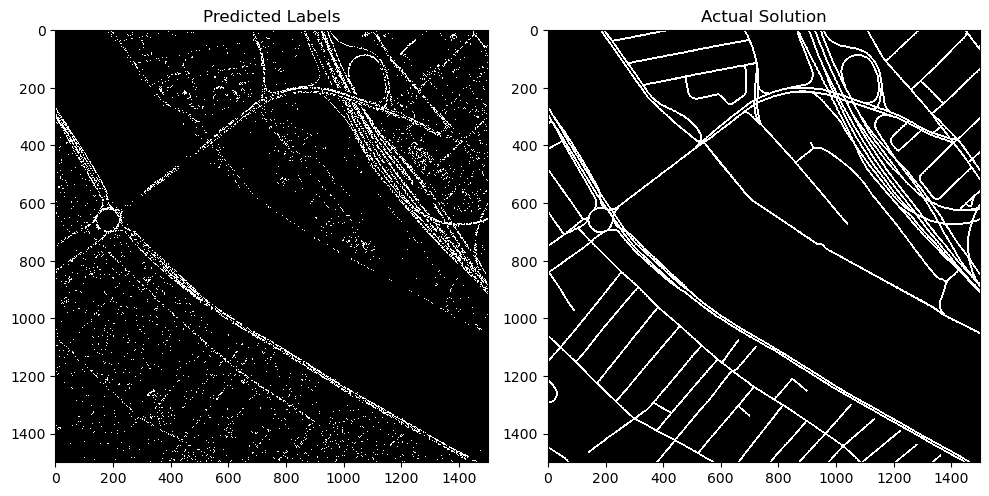

In [11]:
# Convert predictions to image
train_preds = model1_pred.reshape(small_ans.shape[0], small_ans.shape[1])

# Create figure
fig, ax = plt.subplots(1, 2, figsize = (10, 6))

skio.imshow(train_preds, ax = ax[0])
ax[0].set_title("Predicted Labels")

skio.imshow(small_ans, ax = ax[1])
ax[1].set_title("Actual Solution");

Visually, our solution looks alright, but it obviously has room for improvement.
Let's see what our results look like on the testing data.

## Test model

In [16]:
# Flatten images
test_small_rgb = small_rgb_test.reshape(small_rgb_test.shape[0]*small_rgb_test.shape[1], 3)
y_test = small_ans_test.reshape(small_ans_test.shape[0]*small_ans_test.shape[1])

In [17]:
# Predictions on testing data
model1_test_pred = model1.predict(test_small_rgb)

# Confusion matrix
accuracy_metrics(y_test, model1_test_pred)

Confusion matrix:
 [[2070111   39624]
 [ 120359   19906]]
Overall accuracy: 0.929 
True positive rate (not road): 0.981 
True negative rate (roads) 0.142


While we still have a good overall accuracy rate, our predictions of roads is substantially worse.
We have only classified 8.3% of the road pixels correctly.

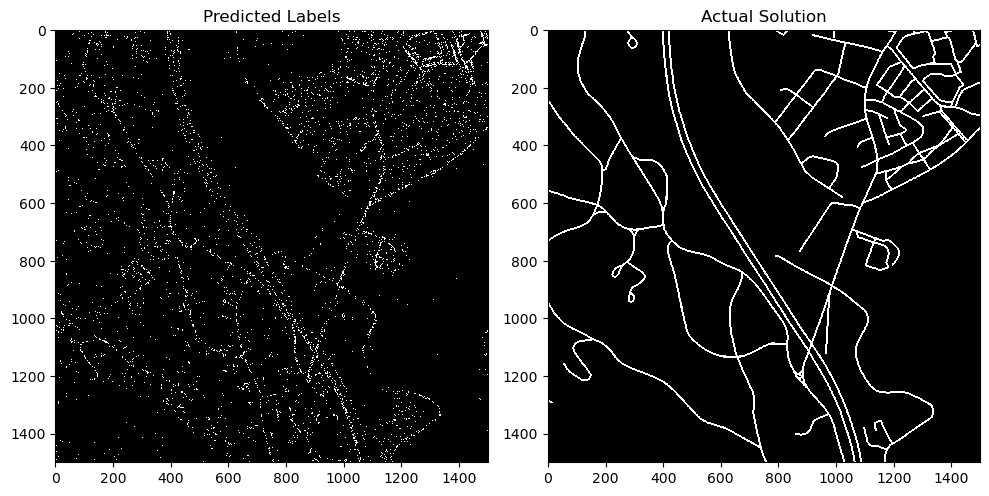

In [18]:
# Convert predictions to image
test_preds = model1_test_pred.reshape(small_ans_test.shape[0], small_ans_test.shape[1])

# Create figure
fig, ax = plt.subplots(1, 2, figsize = (10, 6))

skio.imshow(test_preds, ax = ax[0])
ax[0].set_title("Predicted Labels")

skio.imshow(small_ans_test, ax = ax[1])
ax[1].set_title("Actual Solution");

Our model did NOT generalize well! This looks terrible!

# Incorporating Additional Layers

## Train Model

In [19]:
# Create additional features

# Range of values (gray pixels will have low range)
r = small_rgb.max(axis = 2) - small_rgb.min(axis = 2)

# Canny edge detection
canny_edges_r = feature.canny(small_rgb[:,:,0], sigma=4);
canny_edges_g = feature.canny(small_rgb[:,:,1], sigma=4);
canny_edges_b = feature.canny(small_rgb[:,:,2], sigma=4);

# Gaussian blur sigma = 1
gaus_r_1 = gaussian_filter(small_rgb[:,:,0], sigma = 1)
gaus_g_1 = gaussian_filter(small_rgb[:,:,1], sigma = 1)
gaus_b_1 = gaussian_filter(small_rgb[:,:,2], sigma = 1)

# Gaussian blur sigma = 3
gaus_r_3 = gaussian_filter(small_rgb[:,:,0], sigma = 3)
gaus_g_3 = gaussian_filter(small_rgb[:,:,1], sigma = 3)
gaus_b_3 = gaussian_filter(small_rgb[:,:,2], sigma = 3)

# Gaussian blur sigma = 5
gaus_r_5 = gaussian_filter(small_rgb[:,:,0], sigma = 5)
gaus_g_5 = gaussian_filter(small_rgb[:,:,1], sigma = 5)
gaus_b_5 = gaussian_filter(small_rgb[:,:,2], sigma = 5)

# LoG blur sigma = .5
log_r_5 = gaussian_laplace(small_rgb[:,:,0], sigma = .5)
log_g_5 = gaussian_laplace(small_rgb[:,:,1], sigma = .5)
log_b_5 = gaussian_laplace(small_rgb[:,:,2], sigma = .5)

# LoG blur sigma = .6
log_r_6 = gaussian_laplace(small_rgb[:,:,0], sigma = .6)
log_g_6 = gaussian_laplace(small_rgb[:,:,1], sigma = .6)
log_b_6 = gaussian_laplace(small_rgb[:,:,2], sigma = .6)

# LoG blur sigma = .8
log_r_8 = gaussian_laplace(small_rgb[:,:,0], sigma = .8)
log_g_8 = gaussian_laplace(small_rgb[:,:,1], sigma = .8)
log_b_8 = gaussian_laplace(small_rgb[:,:,2], sigma = .8)

# Add layers to model
small_rgb_layers = np.dstack([small_rgb, r, canny_edges_r, canny_edges_g, canny_edges_b,
                             gaus_r_1, gaus_g_1, gaus_b_1, gaus_r_3, gaus_g_3, gaus_b_3,
                             gaus_r_5, gaus_g_5, gaus_b_5, log_r_5, log_g_5, log_b_5,
                             log_r_6, log_g_6, log_b_6, log_r_8, log_g_8, log_b_8])

In [22]:
# Train model

# Flatten image
train_small_rgb_layers = small_rgb_layers.reshape(small_rgb_layers.shape[0]*small_rgb_layers.shape[1], 25)

# Create model
RF = RandomForestClassifier()

# Fit and output the performance of the model
model2 = RF.fit(train_small_rgb_layers, y_train)

# Predictions on training data
model2_pred = model2.predict(train_small_rgb_layers)

# Confusion matrix
accuracy_metrics(y_train, model2_pred)

Confusion matrix:
 [[2041420       0]
 [     39  208541]]
Overall accuracy: 1.0 
True positive rate (not road): 1.0 
True negative rate (roads) 1.0


Before adding the additional layers to our training data, our overall accuracy was 0.954, true positive rate (not road) was 0.986, and true negative rate (roads) was 0.687 (may change slightly in different runs).
Now we have virtually perfect results!
Let's look at an image of the output.

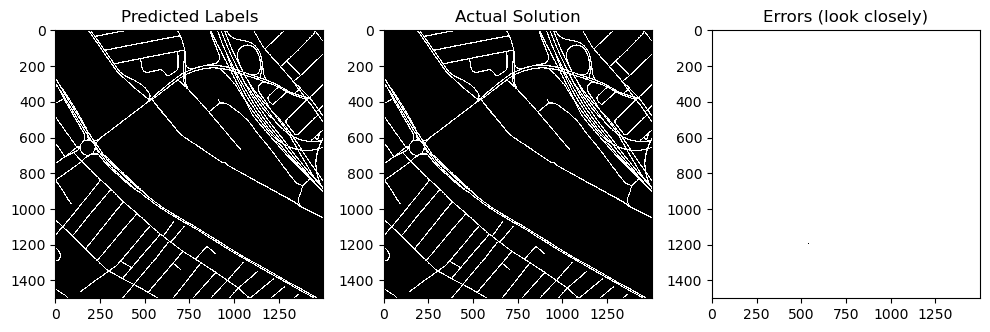

In [28]:
# Convert predictions to image
train_preds = model2_pred.reshape(small_ans.shape[0], small_ans.shape[1])

# Create figure
fig, ax = plt.subplots(1, 3, figsize = (10, 6))

skio.imshow(train_preds, ax = ax[0])
ax[0].set_title("Predicted Labels")

skio.imshow(small_ans, ax = ax[1])
ax[1].set_title("Actual Solution")

skio.imshow(train_preds==small_ans, ax = ax[2])
ax[2].set_title("Errors (look closely)");

Yep, can't even find the errors without looking closely at the difference between the two images.
Let's evaluate our results on the testing data!

## Test Model

In [26]:
# Create additional features

# Range of values (gray pixels will have low range)
rt = small_rgb_test.max(axis = 2) - small_rgb_test.min(axis = 2)

# Canny edge detection
canny_edges_rt = feature.canny(small_rgb_test[:,:,0], sigma=4);
canny_edges_gt = feature.canny(small_rgb_test[:,:,1], sigma=4);
canny_edges_bt = feature.canny(small_rgb_test[:,:,2], sigma=4);

# Gaussian blur sigma = 1
gaus_r_1t = gaussian_filter(small_rgb_test[:,:,0], sigma = 1)
gaus_g_1t = gaussian_filter(small_rgb_test[:,:,1], sigma = 1)
gaus_b_1t = gaussian_filter(small_rgb_test[:,:,2], sigma = 1)

# Gaussian blur sigma = 3
gaus_r_3t = gaussian_filter(small_rgb_test[:,:,0], sigma = 3)
gaus_g_3t = gaussian_filter(small_rgb_test[:,:,1], sigma = 3)
gaus_b_3t = gaussian_filter(small_rgb_test[:,:,2], sigma = 3)

# Gaussian blur sigma = 5
gaus_r_5t = gaussian_filter(small_rgb_test[:,:,0], sigma = 5)
gaus_g_5t = gaussian_filter(small_rgb_test[:,:,1], sigma = 5)
gaus_b_5t = gaussian_filter(small_rgb_test[:,:,2], sigma = 5)

# LoG blur sigma = .5
log_r_5t = gaussian_laplace(small_rgb_test[:,:,0], sigma = .5)
log_g_5t = gaussian_laplace(small_rgb_test[:,:,1], sigma = .5)
log_b_5t = gaussian_laplace(small_rgb_test[:,:,2], sigma = .5)

# LoG blur sigma = .6
log_r_6t = gaussian_laplace(small_rgb_test[:,:,0], sigma = .6)
log_g_6t = gaussian_laplace(small_rgb_test[:,:,1], sigma = .6)
log_b_6t = gaussian_laplace(small_rgb_test[:,:,2], sigma = .6)

# LoG blur sigma = .8
log_r_8t = gaussian_laplace(small_rgb_test[:,:,0], sigma = .8)
log_g_8t = gaussian_laplace(small_rgb_test[:,:,1], sigma = .8)
log_b_8t = gaussian_laplace(small_rgb_test[:,:,2], sigma = .8)

# Add layers to model
small_rgb_test_layers = np.dstack([small_rgb_test, rt, canny_edges_rt, canny_edges_gt, canny_edges_bt,
                             gaus_r_1t, gaus_g_1t, gaus_b_1t, gaus_r_3t, gaus_g_3t, gaus_b_3t,
                             gaus_r_5t, gaus_g_5t, gaus_b_5t, log_r_5t, log_g_5t, log_b_5t,
                             log_r_6t, log_g_6t, log_b_6t, log_r_8t, log_g_8t, log_b_8t])

In [27]:
# Flatten image
test_small_rgb_layers = small_rgb_test_layers.reshape(small_rgb_test_layers.shape[0]*small_rgb_test_layers.shape[1], 25)

# Predictions on testing data
model2_test_pred = model2.predict(test_small_rgb_layers)

# Confusion matrix
accuracy_metrics(y_test, model2_test_pred)

Confusion matrix:
 [[2103218    6517]
 [ 133294    6971]]
Overall accuracy: 0.938 
True positive rate (not road): 0.997 
True negative rate (roads) 0.05


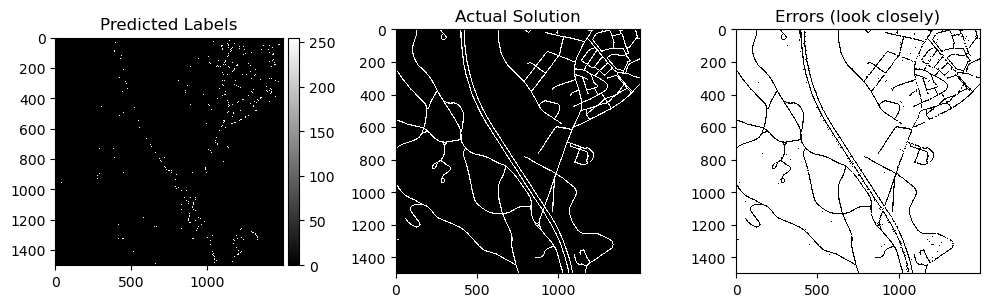

In [33]:
# Convert predictions to image
test_preds = model2_test_pred.reshape(small_ans_test.shape[0], small_ans_test.shape[1])

# Create figure
fig, ax = plt.subplots(1, 3, figsize = (10, 6))

skio.imshow(test_preds, ax = ax[0], cmap = "gray")
ax[0].set_title("Predicted Labels")

skio.imshow(small_ans_test, ax = ax[1])
ax[1].set_title("Actual Solution")

skio.imshow(test_preds==small_ans_test, ax = ax[2])
ax[2].set_title("Errors");

Adding these filters to our model had negligible impact on our results.
It improved the accuracy from 0.906 to 0.927, the true positive rate (not road) from 0.958 to 0.983, but decreased the true negative rate (roads) from 0.086 to 0.046, which is what we were really hoping to improve.
It seems that incorporating these features in our training data led to severe overfitting!